In [1]:
    #from google.colab import drive
#drive.mount('/content/drive')

# Twitter Developer Account
In order to use Twitter’s API, we have to create a developer account on the Twitter apps site.
 * Log in or make a Twitter account at https://apps.twitter.com/.
 * Create a new app (button on the top right)
 
<img src=https://miro.medium.com/max/1400/0*Dq78m3JKoSqZY5SS.png style="width: 200px;">

Fill in the app creation page with a unique name, a website name (use a placeholder website if you don’t have one), and a project description. Accept the terms and conditions and proceed to the next page.

Example Purpose Statement
>>> At the moment I am taking a data science course from 10academy.org initiative. As part of the training, I am working on a project that involves fetching twitter data on a number of African countries related to COVID-19 vaccination topics. To fetch twitter data and make exploratory data analysis, I need to be able to access twitter through its API. This is the main reason why I want to create a developer account. I hope you will look my application favoroubly. 
I have read the terms of use, and I fully agree with it. Twitter is a great source of data to study social, economical, and political issus, and I hope to use my data science skills to provide insights on this issues in the future as well.


Once your project has been created, click on the “Keys and Access Tokens” tab. You should now be able to see your consumer secret and consumer key.

<img src=https://miro.medium.com/max/1400/0*YU1pFqTw6Dn-ZmOd.png style="width: 200px;">

You’ll also need a pair of access tokens. Scroll down and request those tokens. The page should refresh, and you should now have an access token and access token secret.

<img src=https://miro.medium.com/max/1400/0*_gnOgA0aaAqPgDJG.png style="width: 200px;">


## Import necessary modules

In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm

#from tqdm.notebook import nbtqdm
#from tqdm import tqdm
from datetime import datetime, date, time, timedelta
from collections import Counter

import matplotlib.dates as mdates
import seaborn as sns
sns.set()


# to view all columns
pd.set_option("display.max.columns", None)

In [3]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
#!pip install tweepy
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
#!pip install textblob
from textblob import TextBlob

#general text pre-processor
#!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

#tweet pre-processor 
#!pip install tweet-preprocessor
import preprocessor as p

[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')
    
    
def refresh_status_bar(text, verbose=1):
    if verbose:
        print('{}'.format(text),file=sys.stderr, end="")

### Starting code
Below we define some starting codes (python classes and function) to illustrate and assist on how to fetch data from twitter and analyse them. 

### **Your task is**
1. Go through the code and understand it. Know what each function does
2. If you find error, fix it. Ask for help in the slack channel if you find serious mistake
3. Extend the code such that it will be useful for topics you choose to analyse
4. Make nice plots and share your finding (e.g.  insight on the main covid19 twitter converstions about your country)
5. Submit what ever you managed to do by Wednesday morning. But you should keep using what you build to write blogs, share on facebook, etc. 

In [20]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(tweepy.Stream):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='data/tweets.json',
                      keywords=['COVID19KE'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('Tweet Keywords are: ',keywords)
    print('For testing case, please interupt the downloading process \
            using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
    

    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None

def read_tweet_json(tweets_file,verbose=1, func=lambda x:x, nmax=0):
    '''
    Read a twitter raw json dumped file into a list.
    It attempts two methods:
        1) read line by line and parse each line using json.loads
        2) assuming there was no \n used, load everything, replace 
    '''
    #
    
    try:     
        print('trying method 1')
        tweets_data = []
        iline = 0
        num_failed=0
        
        for line in open(tweets_file, "r"):
            try:
                tweet = func(json.loads(line.strip()))
                tweets_data.append(tweet)
            except:
                print(f'failed to process line={iline}')
                num_failed += 1
                #print(line)
            if nmax>0 and iline>nmax:
                break
                
            iline += 1
             
    except:
        iline = 0
        num_failed=0
        
        print('trying method 2')
        with open(tweets_file) as f:
            tweets_data = json.loads("[" + f.read().replace("}\n{", "},\n{") + '{}'+ "]")  
            
        tweets_data = [func(status) for status in tweets_data]
    #    
    if verbose>0:
        print(f'#tweets from {tweets_file}: {len(tweets_data)}')
        print(f'number of lines failed to read: {num_failed}' )
        
    return tweets_data




class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None, **kwargs):
        #
        
        self.verbose = kwargs.get('verbose',1)
        
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
            


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth,wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            
    def limit_status(self):
        return self.api.rate_limit_status()

    def clean_tweets(self, twitter_text):

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)
        
        #use pre processor
        tweet = p.clean(twitter_text)
        
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        return tweet
    

        
        stop_words = set(stopwords.words('english'))
        try:
            word_tokens = nltk.word_tokenize(tweet)
        except:
            #print(f'word_tokenize failed for cleaned tweet: {tweet}')
            pass
        
        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet) 
    

    def get_user_data(self,target):
    
        #test if screen name exists 
        try:
            #print("Getting data for " + target)
            item = self.api.get_user(target)  
            
            #derived params
            tweets = item.statuses_count
            account_created_date = item.created_at
            delta = datetime.utcnow() - account_created_date
            account_age_days = delta.days
            average_tweet_per_day = float(tweets)/float(account_age_days)
            
            item = item._json
            item['account_age_days'] = account_age_days
            item['average_tweet_per_day'] = average_tweet_per_day
            
        except tweepy.TweepError as e:
            print()
            print(f"ERROR CODE: {e.args[0][0]['code']}: {e.args[0][0]['message']}")
            print(f'issue with reading screen_name = {target}')
            item = None
            
        return item
            
            
    def get_screen_names(self,users, **kwargs):
        
        csv = kwargs.get('csv',False)
        col = kwargs.get('col','twitter_handle')
        nusers = kwargs.get('nusers',0)
        
        if csv:
            try:
                print(users)
                df = pd.read_csv(users)
                print(df.head())
                users = df[col].to_list()
            except:
                print(f'failing to get users name from column={col} of file {users}' )
                raise
        else:
            if not isinstance(users, (list, tuple, set)):
                print('Provided users input is not list or tuple. The type(users)',type(users))
            
        #allow to get only few numbers
        users_to_get = users
        if nusers>0 and nusers<=len(users):
            users_to_get = users[0:nusers]
            
        return users_to_get
    
    def get_users_info(self,users, 
                      csv=True, 
                      col='Name',                        
                      nusers=0, 
                      fname=None,
                      **kwargs):
        '''
        This function returns User Objects
        The User object contains Twitter User account metadata 
        that describes the Twitter User referenced. Users can author 
        Tweets, Retweet, quote other Users Tweets, 
        reply to Tweets, follow Users, be @mentioned in 
        Tweets and can be grouped into lists.
        
        REF
        https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object
        '''
        users_to_get = self.get_screen_names(users,
                                      csv=csv,
                                      col=col, 
                                      nusers=nusers,
                                      fname=None,
                                      **kwargs)
                        
            
        info_list = []
        for target in users_to_get:
            
            item = self.get_user_data(target)
            if item is None:
                continue

            if kwargs.get('verbose',self.verbose)>2:
                print("name: " + item['name'])
                print("screen_name: " + item['screen_name'])
                print("description: " + item['description'])
                print("statuses_count: " + str(item['statuses_count']))
                print("friends_count: " + str(item['friends_count']))
                print("followers_count: " + str(item['followers_count']))
                print("account created date: ",item['created_at'])
                print("Account age (in days): " + str(item['account_age_days']))
                if item['average_tweet_per_day'] > 0:
                      print("Average tweets per day: " + "%.2f"%(item['average_tweet_per_day'])) 
                                    

            info_list.append(item)
            
        df = pd.DataFrame(info_list)
        
        #save
        if not fname is None:
            df.to_csv(fname)
            
        return df
    
    def print_most_common(self,t):
        mentions = t['mentions']
        hashtags = t['hashtags']
        tweet_count = t['tweet_count']
        
        
        print()
        print("Most mentioned Twitter users:")
        for item, count in Counter(mentions).most_common(10):
          print(item + "\t" + str(count))

        print()
        print("Most used hashtags:")
        for item, count in Counter(hashtags).most_common(10):
          print(item + "\t" + str(count))

        print()
        print("All done. Processed " + str(tweet_count) + " tweets.")

    
    def status_to_entities(self,status):
        hashtags = []
        mentions = []
        
        #get some attributes in separate list
        if hasattr(status, "entities"):
            entities = status.entities
            #
            if "hashtags" in entities:
                for ent in entities["hashtags"]:
                    if ent is not None:
                        if "text" in ent:
                            hashtag = ent["text"]
                            if hashtag is not None:
                                hashtags.append(hashtag)


            if "user_mentions" in entities:
                for ent in entities["user_mentions"]:
                    if ent is not None:
                        if "screen_name" in ent:
                            name = ent["screen_name"]
                            if name is not None:
                                mentions.append(name) 
                            
        return mentions, hashtags
    
    def entities_dict(self,status):
        mentions, hashtags = self.status_to_entities(status)
        
        #
        entdict = {'nmention':len(mentions), 'nhashtag':len(hashtags),
                   'mentions':'|'.join(mentions),'hashtags':'|'.join(hashtags)}
        
        #
#         for item, count in Counter(mentions).most_common(10):
#             entdict['%s_mentions'%item] = count
            
#         for item, count in Counter(hashtags).most_common(10):
#             entdict['%s_count'%item] = count    
            
        return entdict
    
    
    def get_all_tweets(self,screen_name, 
                       fname=None,
                       ndays=10000, 
                       nitem=10000):
        #Twitter only allows access to a users most recent 3240 tweets with this method
        '''
        Entities provide metadata and additional contextual information 
        about content posted on Twitter. The entities section provides 
        arrays of common things included in Tweets: 
        hashtags, user mentions, links, stock tickers (symbols),
        Twitter polls, and attached media. 
        
        More Ref:
        https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object
        '''
        #
        name = screen_name.replace('@','')
        
        #
        item = self.get_user_data(screen_name)
        if item is None:
            return []

                
        if fname is None:
            name = screen_name.replace('@','')
            fname = f'users_tweets/{name}_tweets.json'
            
        fhandle = open(fname, 'w')
        
        #initialize a list to hold all the tweepy Tweets
        alltweets = []  #tweet object sotre
        allentities = []  #entities object store

        
        #filter tweets by date
        if ndays>0:
            end_date = datetime.utcnow() - timedelta(days=ndays)
        else:
            end_date = None
        
        
        #iterate on status
        tweet_count = 0
        pbar = tqdm(total=3200) 
        for tweet_obj in tweepy.Cursor(self.api.user_timeline, id=screen_name).items(nitem):
            tweet_count += 1
            
            #get dict
            status = tweet_obj._json
            
            alltweets.append(status)   
            
            #write to json 
            json.dump(status,fhandle)
            fhandle.write('\n')
            
            #progress bar
            pbar.set_description(f"{name}: {tweet_count} tweets downloaded so far")
            #pbar.update(10)
                
            #apply date filter
            if not end_date is None:
                if status.created_at < end_date:
                    break  
                    
            
            
        
        #write to json        
        #with open(fname, 'w') as f:
        #    json.dump(alltweets,f)
        fhandle.close()
        pbar.close()
        
        return alltweets

            
    def get_users_tweet(self, users, 
                        csv=True,
                        col='twitter_handle',                        
                        nusers=0, 
                        overwrite=False,
                        call_api=False,
                        **kwargs):
        #
        #
        users_to_get = self.get_screen_names(users,
                                      csv=csv,
                                      col=col, 
                                      nusers=nusers)
        
        alluserstweets = []
        #
        for screen_name in users_to_get:
            name = screen_name.replace('@','')
            fname = f'users_tweets/{name}_tweets.json'
            #print(fname, 'file exists: ',os.path.exists(fname))
            
            #
            if os.path.exists(fname) and not overwrite:
                #
                alltweets = read_tweet_json(fname) #json.load(open(fname,'r'))
                if len(alltweets)==0:
                    print(f"No lines found in file {fname}")
                    continue
                
            else:
                if call_api:
                    try:
                        alltweets = self.get_all_tweets(screen_name,**kwargs)
                    except tweepy.TweepError as e:
                        print(f"Skipping {screen_name} .. error: {e.args[0][0]['message']}") 
                        continue
                else:
                    print(f"Skipping {screen_name} .. no local data found and call_api=False")
                    continue

                
            if len(alltweets)==0:
                continue
            else:
                #transform the tweepy tweets into a 2D array that will populate DataFrame 
                outtweets = [{'id':tweet["id_str"], 
                              'created_at':tweet["created_at"], 
                              'retweet_count':tweet["retweet_count"],
                              'favorite_count':tweet["favorite_count"],
                              'is_retweet': 'retweeted_status' in tweet.keys(),
                              'is_quoted': tweet["is_quote_status"],
                              'reply_to_status': tweet["in_reply_to_status_id_str"],
                              'reply_to_user':tweet["in_reply_to_user_id_str"],
                              'reply_to_username':tweet["in_reply_to_screen_name"],
                              'coord':tweet["coordinates"],
                              'source':tweet["source"],
                              'truncated': tweet["truncated"],                              
                              'text':tweet["text"], 
                              **self.entities_dict(tweet)} for tweet in alltweets]

                alluserstweets.append(pd.DataFrame(outtweets))
            
        return alluserstweets
            
            
    def status_sentiment_info(self,status, df=None):

        #if this tweet is a retweet update retweet count
        if not df is None:
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                #
                cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                if cond1 or cond2:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                    
            return []

        #calculate sentiment
        filtered_tweet = self.clean_tweets(status['full_text'])
        blob = TextBlob(filtered_tweet)
        Sentiment = blob.sentiment     
        polarity = Sentiment.polarity
        subjectivity = Sentiment.subjectivity

        
        new_entry = [status['id'], status['created_at'],
                      status['source'], status['full_text'], filtered_tweet, 
                      Sentiment,polarity,subjectivity, status['lang'],
                      status['favorite_count'], status['retweet_count']]

        new_entry.append(status['user']['screen_name'])

        try:
            is_sensitive = status['possibly_sensitive']
        except KeyError:
            is_sensitive = None

        new_entry.append(is_sensitive)

        hashtags = ", ".join([hashtag_item['text'] for hashtag_item in \
                              status['entities']['hashtags']])
        new_entry.append(hashtags) #append the hashtags

        #
        mentions = ", ".join([mention['screen_name'] for mention in \
                              status['entities']['user_mentions']])
        new_entry.append(mentions) #append the user mentions

        try:
            xyz = status['place']['bounding_box']['coordinates']
            coordinates = [coord for loc in xyz for coord in loc]
        except TypeError:
            coordinates = None
        #
        new_entry.append(coordinates)

        try:
            location = status['user']['location']
        except TypeError:
            location = ''
        #
        new_entry.append(location)  
        
        return new_entry
            
    def get_tweets(self, keyword, fname, csvfile=None, 
                   append=True, npages=100,ncount=1000,
                   nmax=0, overwrite=False):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        #read csv and return if append is False
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            
        fhandle = None
        
        #progress bar initiate
        icount = 0
        ipage = 0
        
        #
        pbar = tqdm(total=ncount*int(max([40,ncount])) )
        print(f'search & download with keyword: {keyword}')
        
        alltweets = []
        
        #check if json file exists
        if os.path.exists(fname) and not (overwrite or append):
            print(f'Reading existing {fname} file')
            
            alltweets = read_tweet_json(fname, func=self.status_sentiment_info, nmax=nmax)    

        else:      
            #call api, get data, save tweets to json
            
            print('Calling tweepy.Cursor with self.api.search_tweets .. ')
            
            if append and os.path.exists(fname):
                fhandle = open(fname, 'a')
            else:             
                fhandle = open(fname, 'w')                
            
            
            #page attribute in tweepy.cursor and iteration
            for page in tweepy.Cursor(self.api.search_tweets, q=keyword,count=ncount, 
                                      include_rts=False,tweet_mode='extended').pages(npages):

                # the you receive from the Twitter API is in a JSON format and has quite an 
                # amount of information attached
                print('page item: len(page)=',len(page))
                
                for status in page:


                    status = status._json

                    #write to json 
                    json.dump(status,fhandle)
                    fhandle.write('\n')

                    #filter by language
                    #if status['lang'] != 'en':
                    #    continue

                    new_entry = self.status_sentiment_info(status,df=df)
                    if len(new_entry)>0:
                        alltweets.append(new_entry)

                    #info                
                    #pbar.set_description(f"tweets downloaded so far: {icount}")
                    #pbar.update(1)
                    icount += 1

                ipage += 1
                print(f'page={ipage}, #tweet={icount}')
            

        #close open states
        print(f'keyword: {keyword}')
        print(f"total #tweets downloaded: {len(alltweets)}")
        pbar.close()
        
        #close file if open
        if not fhandle is None:
            fhandle.close()
        
        
        #now append a row to the dataframe
        df_new = pd.DataFrame(alltweets, columns=self.cols)
        try:
            df = pd.concat([df_new, df]).drop_duplicates()
        except:
            df = df_new
        
    
        #
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)
        
        if not csvfile is None:
            #save it to file
            try:
                df.to_csv(csvfile, columns=self.cols, index=True, encoding="utf-8")
            except:
                pass
            

        return df

In [ ]:
# name = 'Alemnew'
# title = 'Mr'
# print('Method 1: My name is %s %s'%(title, name))
# print('Method 2: My name is {0} {1}'.format(title, name))
# print('Method 2.1: My name is {title} {name}'.format(**{'title':title, 'name':name}))
# print('Method 2.2: My name is {title} {name}'.format(title=title, name=name))
# print(f'Method 3: My name is {title} {name}')

## Search tweets of users by screen name
Here we are going to get the twitter information of users. Initialise class

In [ ]:
#ts = tweetsearch()
#ts.limit_status()

In [23]:
ts = tweetsearch()

fname = 'data/ethiopia_nomore.csv'

overwrite = False
append = False

#keyword = ['NOMORE','nomore','no_more','NoMore']
keyword = ['ethiopia']
dfig = ts.get_tweets(keyword, fname,overwrite=overwrite, append=append, nmax=0,  ncount=1000, npages=1000)


  0%|                                                                   | 0/1000000 [00:00<?, ?it/s]

search & download with keyword: ['ethiopia']
Reading existing data/ethiopia_nomore.csv file
trying method 1
failed to process line=15547
failed to process line=16497
failed to process line=16780
failed to process line=16781
failed to process line=71106
failed to process line=84818
failed to process line=84819
failed to process line=111397
failed to process line=127994
failed to process line=147589
failed to process line=152657
failed to process line=152659


  0%|                                                                   | 0/1000000 [02:37<?, ?it/s]

#tweets from data/ethiopia_nomore.csv: 156448
number of lines failed to read: 12
keyword: ['ethiopia']
total #tweets downloaded: 156448


In [221]:
dfig.info() #[(df.location=='Ethiopia') & (df_users.excess_followers>200)]
#dff #.head()
#dff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156448 entries, 2021-12-25 09:51:10+00:00 to 2021-12-27 21:54:58+00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              156448 non-null  object 
 1   source                  156448 non-null  object 
 2   original_text           156448 non-null  object 
 3   clean_text              156448 non-null  object 
 4   sentiment               156448 non-null  object 
 5   polarity                156448 non-null  float64
 6   subjectivity            156448 non-null  float64
 7   lang                    156448 non-null  object 
 8   favorite_count          156448 non-null  int64  
 9   retweet_count           156448 non-null  int64  
 10  original_author         156448 non-null  object 
 11  possibly_sensitive      25352 non-null   object 
 12  hashtags                156448 non-null  object 
 13  user_mentions           1564

In [238]:
def hashtags(post):
    tag = {}
    for sentence in post:
        words = sentence.split(",")
        for w in words:
            if len(w) > 0:
                word = w.strip()
                if word in tag.keys():
                    tag[word] +=1
                else:
                    tag[word] = 1
    return tag            

In [239]:
post = dfig["hashtags"]
dichash = hashtags(post)

In [323]:
dfhash = pd.Series(dichash)

In [324]:
dfhash = dfhash.sort_values(ascending = False).head(100)

In [325]:
print(dfhash.head(60),dfhash.tail(40))

Ethiopia                      45875
Tigray                        27025
NoMore                        14053
TigrayGenocide                 9558
KnowMore                       6153
Eritrea                        5089
Africa                         4778
StopDroneAttacks               4173
US                             3203
TigrayIsAfrica                 2953
Tigraygenocide                 2935
Turkey                         2898
UnityForEthiopia               2548
Biden                          2471
Blinken                        2402
AGOA                           2382
Tigrayans                      2192
StopWarOnTigray                2191
TerroristTPLF                  2031
TPLF                           1849
NoFlyZoneInTigray              1787
EtiyopyayıSilahlandırmayın     1751
IC                             1651
China                          1609
UN                             1595
TPLFTerroristGroup             1592
UAE                            1540
Amhara                      

In [367]:
plthash = dfhash.head(10)


In [368]:
plthash=plthash.to_dict()

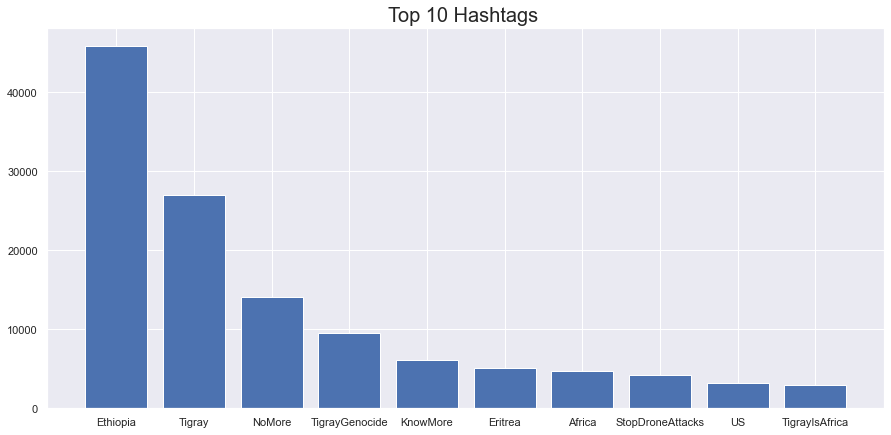

In [369]:
#ploting top 5 hashtag
ind = np.arange(len(plthash))
fig,ax = plt.subplots(figsize =(15,7))
ax.set_title("Top 10 Hashtags ", fontsize = 20)
plt.bar(ind, list(plthash.values()))
plt.xticks(ind, list(plthash.keys()))
plt.show()